# Credit score classification - grupa nr 5: Wojtek Grabias, Wiktor Wierzchowski

## importy, split i funkcje

In [1]:
%%capture --no-stderr

import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df_original = pd.read_csv('train.csv', low_memory=False)

df, X_test, df_target, y_test = train_test_split(
    df_original[df_original.columns.values[:-1]], # X
    df_original[df_original.columns.values[-1]], # y
    test_size=0.33, random_state=42)

In [3]:
def History_Age_2_months(df):
    df['Credit_History_Age'] = df['Credit_History_Age'].str.replace(' Months', '')
    return df['Credit_History_Age'].str.replace('\D+', '* 12 +')
def Object_to_Numeric(df, s):
    return pd.to_numeric(df[s].str.replace('_', ''))

## podstawowe zaznajomienie z ramką

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67000 entries, 59428 to 15795
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        67000 non-null  object 
 1   Customer_ID               67000 non-null  object 
 2   Month                     67000 non-null  object 
 3   Name                      60306 non-null  object 
 4   Age                       67000 non-null  object 
 5   SSN                       67000 non-null  object 
 6   Occupation                67000 non-null  object 
 7   Annual_Income             67000 non-null  object 
 8   Monthly_Inhand_Salary     56942 non-null  float64
 9   Num_Bank_Accounts         67000 non-null  int64  
 10  Num_Credit_Card           67000 non-null  int64  
 11  Interest_Rate             67000 non-null  int64  
 12  Num_of_Loan               67000 non-null  object 
 13  Type_of_Loan              59303 non-null  object 
 14  De

In [5]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

In [6]:
df['ID'].drop_duplicates().shape[0]
# każdy wiersz ma swoje id więc wszystkie wpisy w tabeli są unikalne
# df = df.drop(columns = ['ID', 'Name', 'SSN'])

67000

## zamiana typów kolumn na numeryczne

In [7]:
df['Outstanding_Debt'] = Object_to_Numeric(df, 'Outstanding_Debt')
df['Amount_invested_monthly'] = Object_to_Numeric(df, 'Amount_invested_monthly')
df['Changed_Credit_Limit'] = Object_to_Numeric(df, 'Changed_Credit_Limit')
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace('_', '')
df = df.astype({'Monthly_Balance': 'float'})

In [8]:
df['Credit_History_Age'] = History_Age_2_months(df)
df['Credit_History_Age'].loc[df.Credit_History_Age.isnull()] = df['Credit_History_Age'].loc[df.Credit_History_Age.isnull()].apply(
        lambda x: '-1') #Brak danych jest teraz -1
df['Credit_History_Age'] = df['Credit_History_Age'].apply(eval)

C:\Users\wwier\AppData\Local\Temp\ipykernel_15524\2355454557.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  return df['Credit_History_Age'].str.replace('\D+', '* 12 +')
C:\Users\wwier\AppData\Local\Temp\ipykernel_15524\2810006821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Credit_History_Age'].loc[df.Credit_History_Age.isnull()] = df['Credit_History_Age'].loc[df.Credit_History_Age.isnull()].apply(


In [9]:
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('Yes', 1)
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('No', 0)
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('NM', 2)
df['Payment_Behaviour'] = np.where(df['Payment_Behaviour']== '!@9#%8', np.nan, df['Payment_Behaviour'])
df['spent'] = np.where('Low' == df['Payment_Behaviour'].str[0:3], 0,1)
df['payment_value'] = df['Payment_Behaviour'].str.extract(r'^(?:[^_]+_){2}([^_ ]+)')

In [10]:
df['payment_value'] = df['payment_value'].replace('Small', 0)
df['payment_value'] = df['payment_value'].replace('Medium', 1)
df['payment_value'] = df['payment_value'].replace('Large', 2)

In [11]:
df['payment_value'] = np.where(df['payment_value'] == 3, np.nan, df['payment_value'])
df = df.drop('Payment_Behaviour', axis=1)

In [12]:
df['Type_of_Loan'] = df['Type_of_Loan'].str.replace('and ', '')
df.Type_of_Loan = df.Type_of_Loan.str.split(', ')
df['Type_of_Loan'].loc[df.Type_of_Loan.isnull()] = df['Type_of_Loan'].loc[df.Type_of_Loan.isnull()].apply(lambda x: [])
mlb = MultiLabelBinarizer(sparse_output=True)
df = df.join(
    pd.DataFrame.sparse.from_spmatrix(
        mlb.fit_transform(df.pop('Type_of_Loan')),
        index=df.index,
        columns=mlb.classes_))

C:\Users\wwier\AppData\Local\Temp\ipykernel_15524\1879291088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type_of_Loan'].loc[df.Type_of_Loan.isnull()] = df['Type_of_Loan'].loc[df.Type_of_Loan.isnull()].apply(lambda x: [])


In [13]:
#2 Month na numeric
df['Month'] = df['Month'].apply(lambda mname: datetime.strptime(mname, '%B').month)

#4 Age na numeric
df['Age'] = df['Age'].convert_dtypes().apply(lambda x: x.replace("_", "")).astype(int)

#7 Annual_Income na numeric
df['Annual_Income'] = df['Annual_Income'].convert_dtypes().apply(lambda x: x.replace("_", "")).astype(float)

#12 Num_of_Loan na numeric
df['Num_of_Loan'] = df['Num_of_Loan'].convert_dtypes().apply(lambda x: x.replace("_", "")).astype(int)

#15 Num_of_Delayed_Payment na numeric
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].convert_dtypes()
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '')
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'])

In [14]:
# Credit_Mix na numeric
df['Credit_Mix'] = df['Credit_Mix'].replace('_', 3)
df['Credit_Mix'] = df['Credit_Mix'].replace('Good', 2)
df['Credit_Mix'] = df['Credit_Mix'].replace('Standard', 1)
df['Credit_Mix'] = df['Credit_Mix'].replace('Bad', 0)

# Credit_Score na numeric
df_target = df_target.replace('Good', 2)
df_target = df_target.replace('Standard', 1)
df_target = df_target.replace('Poor', 0)

In [15]:
df.drop(columns=['ID','Customer_ID','Name','SSN'], inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67000 entries, 59428 to 15795
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   Month                     67000 non-null  int64           
 1   Age                       67000 non-null  int32           
 2   Occupation                67000 non-null  object          
 3   Annual_Income             67000 non-null  float64         
 4   Monthly_Inhand_Salary     56942 non-null  float64         
 5   Num_Bank_Accounts         67000 non-null  int64           
 6   Num_Credit_Card           67000 non-null  int64           
 7   Interest_Rate             67000 non-null  int64           
 8   Num_of_Loan               67000 non-null  int32           
 9   Delay_from_due_date       67000 non-null  int64           
 10  Num_of_Delayed_Payment    62270 non-null  float64         
 11  Changed_Credit_Limit      65570 non-null  float64 

## Usuwanie błędnych wartości

In [17]:
df = df[df.Monthly_Balance != min(df.Monthly_Balance)]
df.Credit_History_Age = np.where(df.Credit_History_Age == -1, np.nan, df.Credit_History_Age)
df.Amount_invested_monthly = np.where(df.Amount_invested_monthly == 10000, np.nan, df.Amount_invested_monthly)
df.Num_Bank_Accounts = np.where(df.Num_Bank_Accounts == -1, np.nan, df.Num_Bank_Accounts)

In [18]:
df['Age'] = np.where(df['Age'] < 0, np.nan, df['Age'])

In [19]:
df['Num_of_Loan'] = np.where(df['Num_of_Loan'] < 0, np.nan, df['Num_of_Loan'])

In [20]:
df['Changed_Credit_Limit'] = np.where(df['Changed_Credit_Limit'] < 0, np.nan, df['Changed_Credit_Limit'])

## Usuwanie nan

In [21]:
#Usunięcie tych, które mają 4 lub więcej nulle
df = df[df.isnull().sum(axis=1) < 4]

In [22]:
df['Age'].fillna(df['Age'].median(), inplace=True) 
df['Monthly_Inhand_Salary'].fillna(df['Monthly_Inhand_Salary'].median(), inplace=True) 
df['Num_Bank_Accounts'].fillna(df['Num_Bank_Accounts'].median(), inplace=True) 
df['Num_of_Loan'].fillna(df['Num_of_Loan'].median(), inplace=True) 
df['Num_of_Delayed_Payment'].fillna(df['Num_of_Delayed_Payment'].median(), inplace=True) 
df['Num_Bank_Accounts'].fillna(df['Num_Bank_Accounts'].median(), inplace=True) 
df['Changed_Credit_Limit'].fillna(df['Changed_Credit_Limit'].median(), inplace=True) 
df['Num_Credit_Inquiries'].fillna(df['Num_Credit_Inquiries'].median(), inplace=True) 
df['Credit_History_Age'].fillna(df['Credit_History_Age'].median(), inplace=True) 
df['Amount_invested_monthly'].fillna(df['Amount_invested_monthly'].median(), inplace=True) 
df['Monthly_Balance'].fillna(df['Monthly_Balance'].median(), inplace=True) 
df['payment_value'].fillna(df['payment_value'].mode(), inplace=True) 

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66888 entries, 59428 to 15795
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   Month                     66888 non-null  int64           
 1   Age                       66888 non-null  float64         
 2   Occupation                66888 non-null  object          
 3   Annual_Income             66888 non-null  float64         
 4   Monthly_Inhand_Salary     66888 non-null  float64         
 5   Num_Bank_Accounts         66888 non-null  float64         
 6   Num_Credit_Card           66888 non-null  int64           
 7   Interest_Rate             66888 non-null  int64           
 8   Num_of_Loan               66888 non-null  float64         
 9   Delay_from_due_date       66888 non-null  int64           
 10  Num_of_Delayed_Payment    66888 non-null  float64         
 11  Changed_Credit_Limit      66888 non-null  float64 

## Poprawienie outlierów i standaryzacja

In [24]:
#kolumny o małych przedziałach wartości zostawiliśmy bez standaryzacji 
stdscaler = StandardScaler()
mmscaler = MinMaxScaler()

df = df.reset_index(drop=True)

Annual_Income

In [25]:
upper_lim = df.Annual_Income.quantile(.99)
lower_lim = df.Annual_Income.quantile(.01)
df.Annual_Income = np.where(df.Annual_Income > upper_lim, upper_lim, df.Annual_Income)

df = df.reset_index(drop=True)
df.Annual_Income = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Annual_Income)),columns=['Annual_Income'])

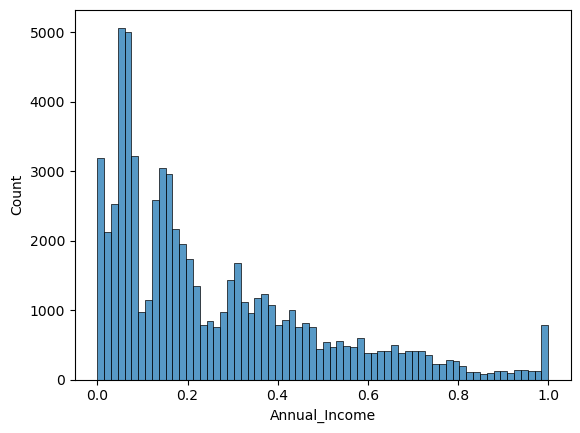

In [26]:
plot_dens=sns.histplot(df['Annual_Income'])

Monthly Balance - jest git, ja bym zostawił bo nie ma outlier'ów - są częścią rozkładu

In [27]:
df.Monthly_Balance = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Monthly_Balance)),columns=['Monthly_Balance'])

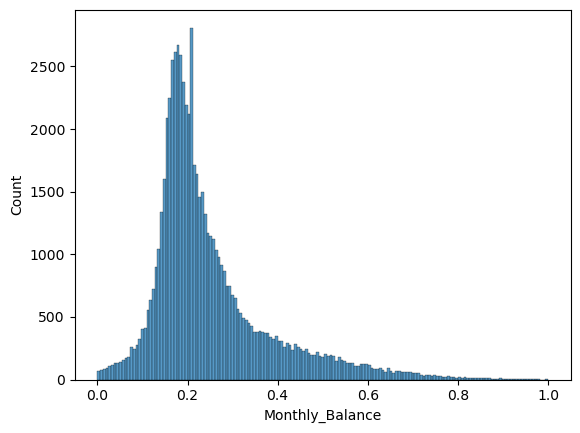

In [28]:
plot_dens=sns.histplot(df['Monthly_Balance'])

Amount_invested_monthly - sprowadzenie do parteru

In [29]:
upper_lim = df.Amount_invested_monthly.quantile(.99)
lower_lim = df.Amount_invested_monthly.quantile(.01)
df.Amount_invested_monthly = np.where(df.Amount_invested_monthly < lower_lim, lower_lim, df.Amount_invested_monthly)
df.Amount_invested_monthly = np.where(df.Amount_invested_monthly > upper_lim, upper_lim, df.Amount_invested_monthly)
df.Amount_invested_monthly = np.log1p(df.Amount_invested_monthly)

df = df.reset_index(drop=True)

In [30]:
df.Amount_invested_monthly = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Amount_invested_monthly)),columns=['Amount_invested_monthly'])

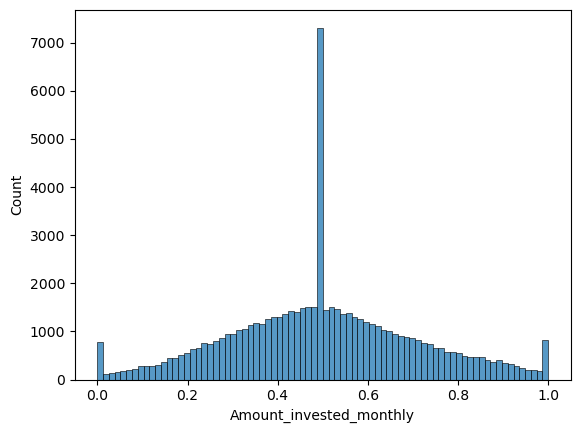

In [31]:
plot_dens=sns.histplot(df['Amount_invested_monthly'])

In [32]:
upper_lim = df.Total_EMI_per_month.quantile(.96)
lower_lim = df.Total_EMI_per_month.quantile(.04)
df.Total_EMI_per_month = np.where(df.Total_EMI_per_month > upper_lim, upper_lim, df.Total_EMI_per_month)
df = df.reset_index(drop=True)

df.Total_EMI_per_month = np.log1p(df.Total_EMI_per_month)

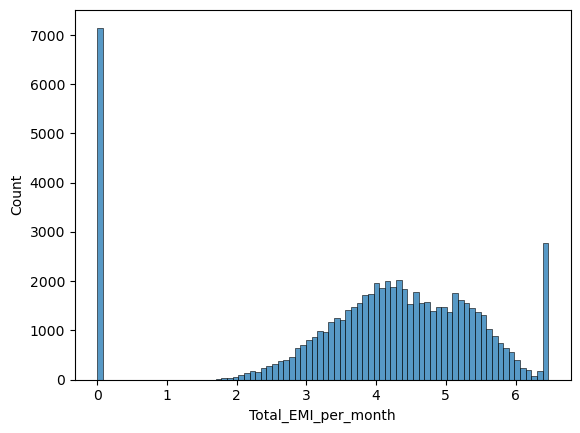

In [33]:
plot_dens=sns.histplot(df['Total_EMI_per_month'])

Credit_Utilization_Ratio - Git, fajny rozkład, zostawiam

In [34]:
df.Credit_Utilization_Ratio = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Credit_Utilization_Ratio)),columns=['Credit_Utilization_Ratio'])

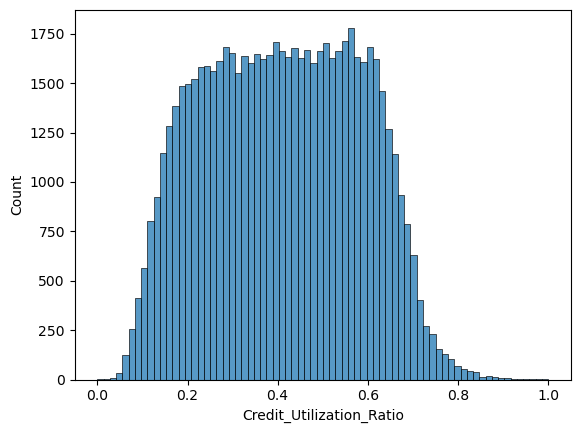

In [35]:
plot_dens=sns.histplot(df['Credit_Utilization_Ratio'])

Outstanding_Debt - nie powiedziałbym że cokoliek jest outlierem

In [36]:
df.Outstanding_Debt = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Outstanding_Debt)),columns=['Outstanding_Debt'])

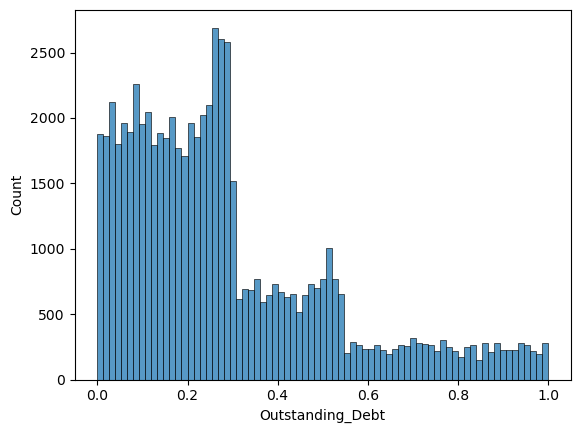

In [37]:
plot_dens=sns.histplot(df['Outstanding_Debt'])

Num_Credit_Inquiries

In [38]:
upper_lim = df.Num_Credit_Inquiries.quantile(.96)
lower_lim = df.Num_Credit_Inquiries.quantile(.04)
df.Num_Credit_Inquiries = np.where(df.Num_Credit_Inquiries > upper_lim, upper_lim, df.Num_Credit_Inquiries)

df = df.reset_index(drop=True)

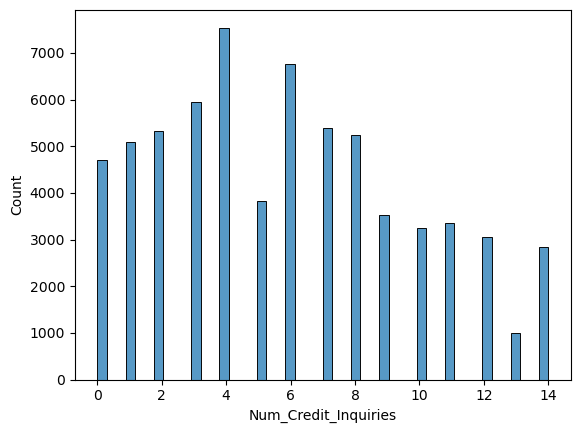

In [39]:
plot_dens=sns.histplot(df['Num_Credit_Inquiries'])

Changed_Credit_Limit

In [40]:
df.Changed_Credit_Limit = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Changed_Credit_Limit)),columns=['Changed_Credit_Limit'])

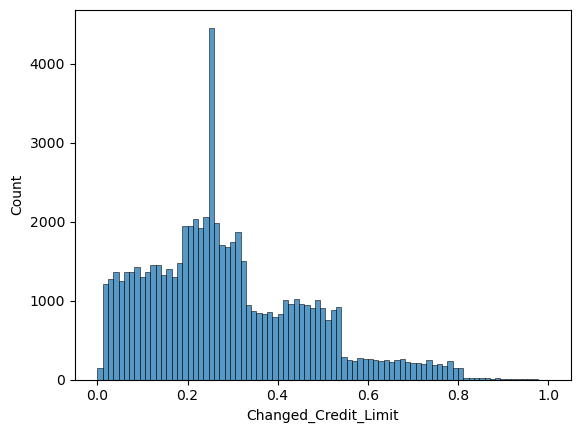

In [41]:
plot_dens=sns.histplot(df['Changed_Credit_Limit'])

In [42]:
upper_lim = df.Age.quantile(.98)
lower_lim = df.Age.quantile(.01)
df.Age = np.where(df.Age > upper_lim, upper_lim, df.Age)
df.Age = np.where(df.Age < lower_lim, lower_lim, df.Age)
df = df.reset_index(drop=True)


df.Age = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Age)),columns=['Age'])

<AxesSubplot:xlabel='Age', ylabel='Count'>

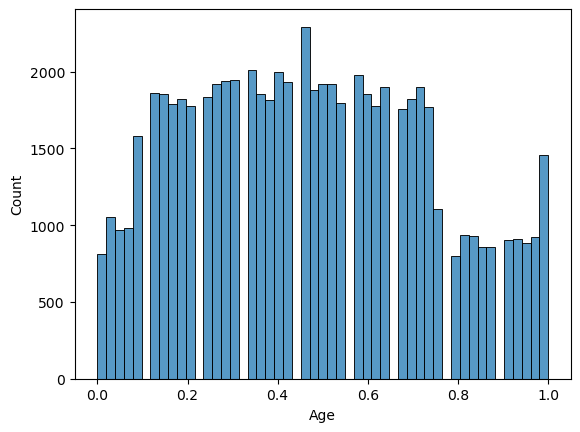

In [43]:
sns.histplot(df.Age)

In [44]:
upper_lim = df.Annual_Income.quantile(.99)
lower_lim = df.Annual_Income.quantile(.01)
df.Annual_Income = np.where(df.Annual_Income > upper_lim, upper_lim, df.Annual_Income)
df.Annual_Income = np.where(df.Annual_Income < lower_lim, lower_lim, df.Annual_Income)

df = df.reset_index(drop=True)

In [45]:
df.Annual_Income = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Annual_Income)),columns=['Annual_Income'])

<AxesSubplot:xlabel='Annual_Income', ylabel='Count'>

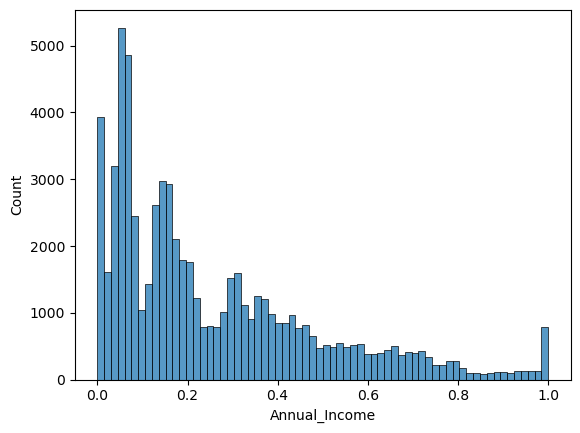

In [46]:
sns.histplot(df.Annual_Income)

In [47]:
factor=3
upper_lim = df['Monthly_Inhand_Salary'].mean () + df['Monthly_Inhand_Salary'].std () * factor
lower_lim = df['Monthly_Inhand_Salary'].mean () - df['Monthly_Inhand_Salary'].std () * factor
df['Monthly_Inhand_Salary'] = np.where(df['Monthly_Inhand_Salary'] < upper_lim, df['Monthly_Inhand_Salary'], upper_lim)
df['Monthly_Inhand_Salary'] = np.where(df['Monthly_Inhand_Salary'] > lower_lim, df['Monthly_Inhand_Salary']
                                       , lower_lim)
df = df.reset_index(drop=True)

df.Monthly_Inhand_Salary = np.log1p(df.Monthly_Inhand_Salary)

In [48]:
df.Monthly_Inhand_Salary = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Monthly_Inhand_Salary)),columns=['Monthly_Inhand_Salary'])

<AxesSubplot:xlabel='Monthly_Inhand_Salary', ylabel='Count'>

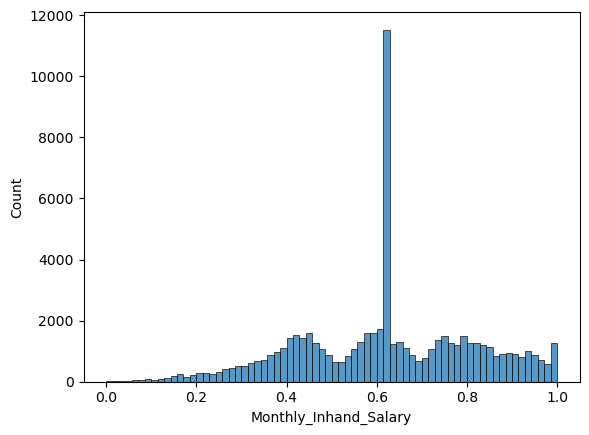

In [49]:
sns.histplot(df.Monthly_Inhand_Salary)

<AxesSubplot:xlabel='Num_Bank_Accounts', ylabel='Count'>

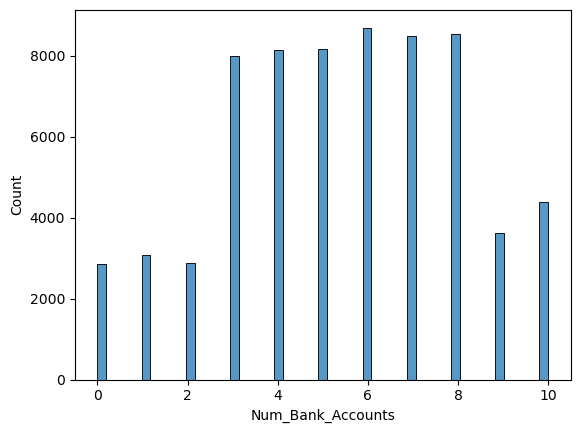

In [50]:
upper_lim = df.Num_Bank_Accounts.quantile(.98)
lower_lim = df.Num_Bank_Accounts.quantile(.00)
df.Num_Bank_Accounts = np.where(df.Num_Bank_Accounts > upper_lim, upper_lim, df.Num_Bank_Accounts)
df.Num_Bank_Accounts = np.where(df.Num_Bank_Accounts < lower_lim, lower_lim, df.Num_Bank_Accounts)
df = df.reset_index(drop=True)

sns.histplot(df.Num_Bank_Accounts)

<AxesSubplot:xlabel='Num_Credit_Card', ylabel='Count'>

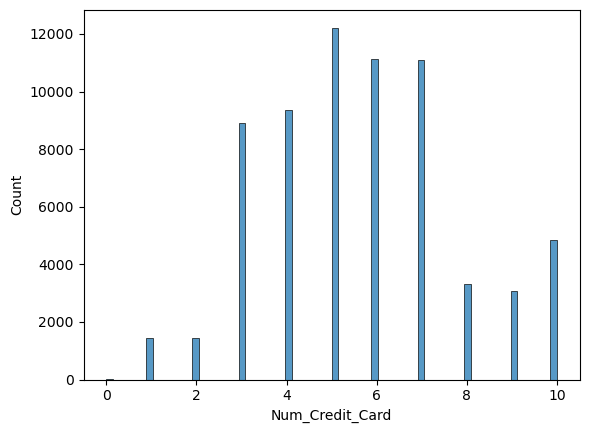

In [51]:
upper_lim = df.Num_Credit_Card.quantile(.97)
lower_lim = df.Num_Credit_Card.quantile(.00)
df.Num_Credit_Card = np.where(df.Num_Credit_Card > upper_lim, upper_lim, df.Num_Credit_Card)
df.Num_Credit_Card = np.where(df.Num_Credit_Card < lower_lim, lower_lim, df.Num_Credit_Card)

df = df.reset_index(drop=True)

sns.histplot(df.Num_Credit_Card)

<AxesSubplot:xlabel='Interest_Rate', ylabel='Count'>

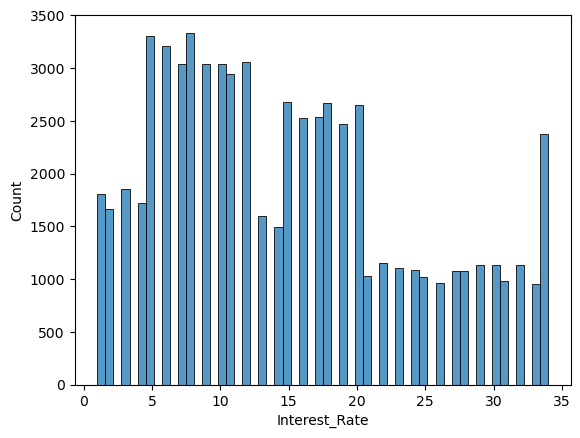

In [52]:
upper_lim = df.Interest_Rate.quantile(.97)
lower_lim = df.Interest_Rate.quantile(.02)
df.Interest_Rate = np.where(df.Interest_Rate > upper_lim, upper_lim, df.Interest_Rate)
df.Interest_Rate = np.where(df.Interest_Rate < lower_lim, lower_lim, df.Interest_Rate)
df = df.reset_index(drop=True)

sns.histplot(df.Interest_Rate)

<AxesSubplot:xlabel='Num_of_Loan', ylabel='Count'>

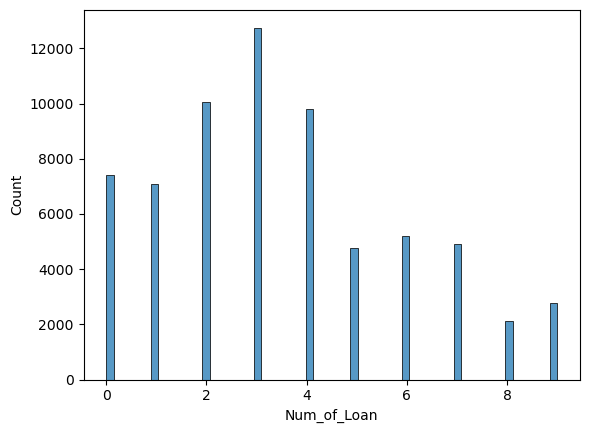

In [53]:
upper_lim = df.Num_of_Loan.quantile(.99)
lower_lim = df.Num_of_Loan.quantile(.00)
df.Num_of_Loan = np.where(df.Num_of_Loan > upper_lim, upper_lim, df.Num_of_Loan)
df.Num_of_Loan = np.where(df.Num_of_Loan < lower_lim, lower_lim, df.Num_of_Loan)
df = df.reset_index(drop=True)

sns.histplot(df.Num_of_Loan)

<AxesSubplot:xlabel='Delay_from_due_date', ylabel='Count'>

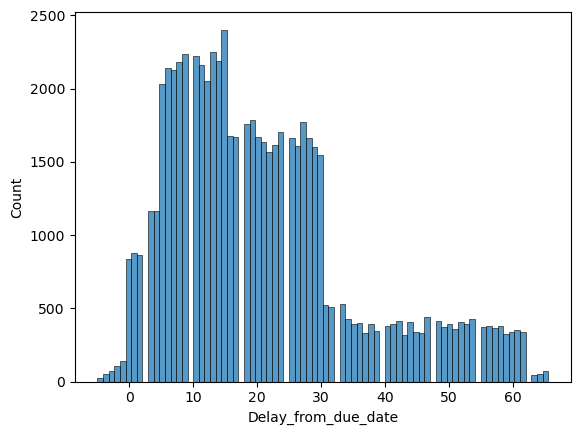

In [54]:
upper_lim = df['Delay_from_due_date'].mean () + df['Delay_from_due_date'].std () * factor
lower_lim = df['Delay_from_due_date'].mean () - df['Delay_from_due_date'].std () * factor
df['Delay_from_due_date'] = np.where(df['Delay_from_due_date'] < upper_lim, df['Delay_from_due_date'], upper_lim)
df['Delay_from_due_date'] = np.where(df['Delay_from_due_date'] > lower_lim, df['Delay_from_due_date'], lower_lim)
df = df.reset_index(drop=True)
 
sns.histplot(df.Delay_from_due_date)

<AxesSubplot:xlabel='Num_of_Delayed_Payment', ylabel='Count'>

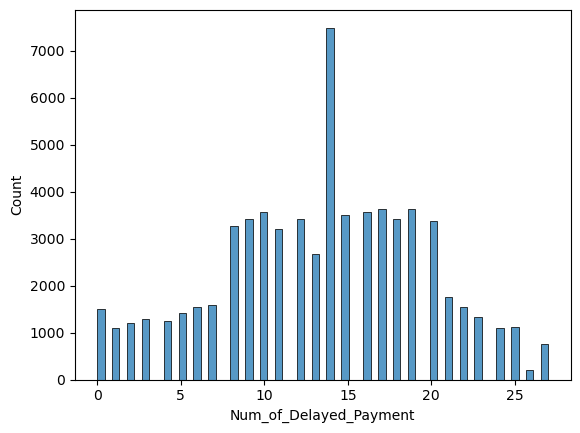

In [55]:
upper_lim = df.Num_of_Delayed_Payment.quantile(.99)
lower_lim = df.Num_of_Delayed_Payment.quantile(.01)
df.Num_of_Delayed_Payment = np.where(df.Num_of_Delayed_Payment > upper_lim, upper_lim, df.Num_of_Delayed_Payment)
df.Num_of_Delayed_Payment = np.where(df.Num_of_Delayed_Payment < lower_lim, lower_lim, df.Num_of_Delayed_Payment)
df = df.reset_index(drop=True)

sns.histplot(df.Num_of_Delayed_Payment)

In [56]:
#df.drop(columns=['Personal Loan','Student Loan','Payday Loan','Not Specified','Mortgage Loan', 'Home Equity Loan','Debt Consolidation Loan', 'Credit-Builder Loan', 'Auto Loan' ], inplace=True)

## Redukcja liczby zmiennych

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66888 entries, 0 to 66887
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   Month                     66888 non-null  int64           
 1   Age                       66888 non-null  float64         
 2   Occupation                66888 non-null  object          
 3   Annual_Income             66888 non-null  float64         
 4   Monthly_Inhand_Salary     66888 non-null  float64         
 5   Num_Bank_Accounts         66888 non-null  float64         
 6   Num_Credit_Card           66888 non-null  float64         
 7   Interest_Rate             66888 non-null  float64         
 8   Num_of_Loan               66888 non-null  float64         
 9   Delay_from_due_date       66888 non-null  float64         
 10  Num_of_Delayed_Payment    66888 non-null  float64         
 11  Changed_Credit_Limit      66888 non-null  float64     

In [58]:
#dużo nanów to się pozbędziemy
df.drop(columns=['payment_value'], inplace = True)

<AxesSubplot:>

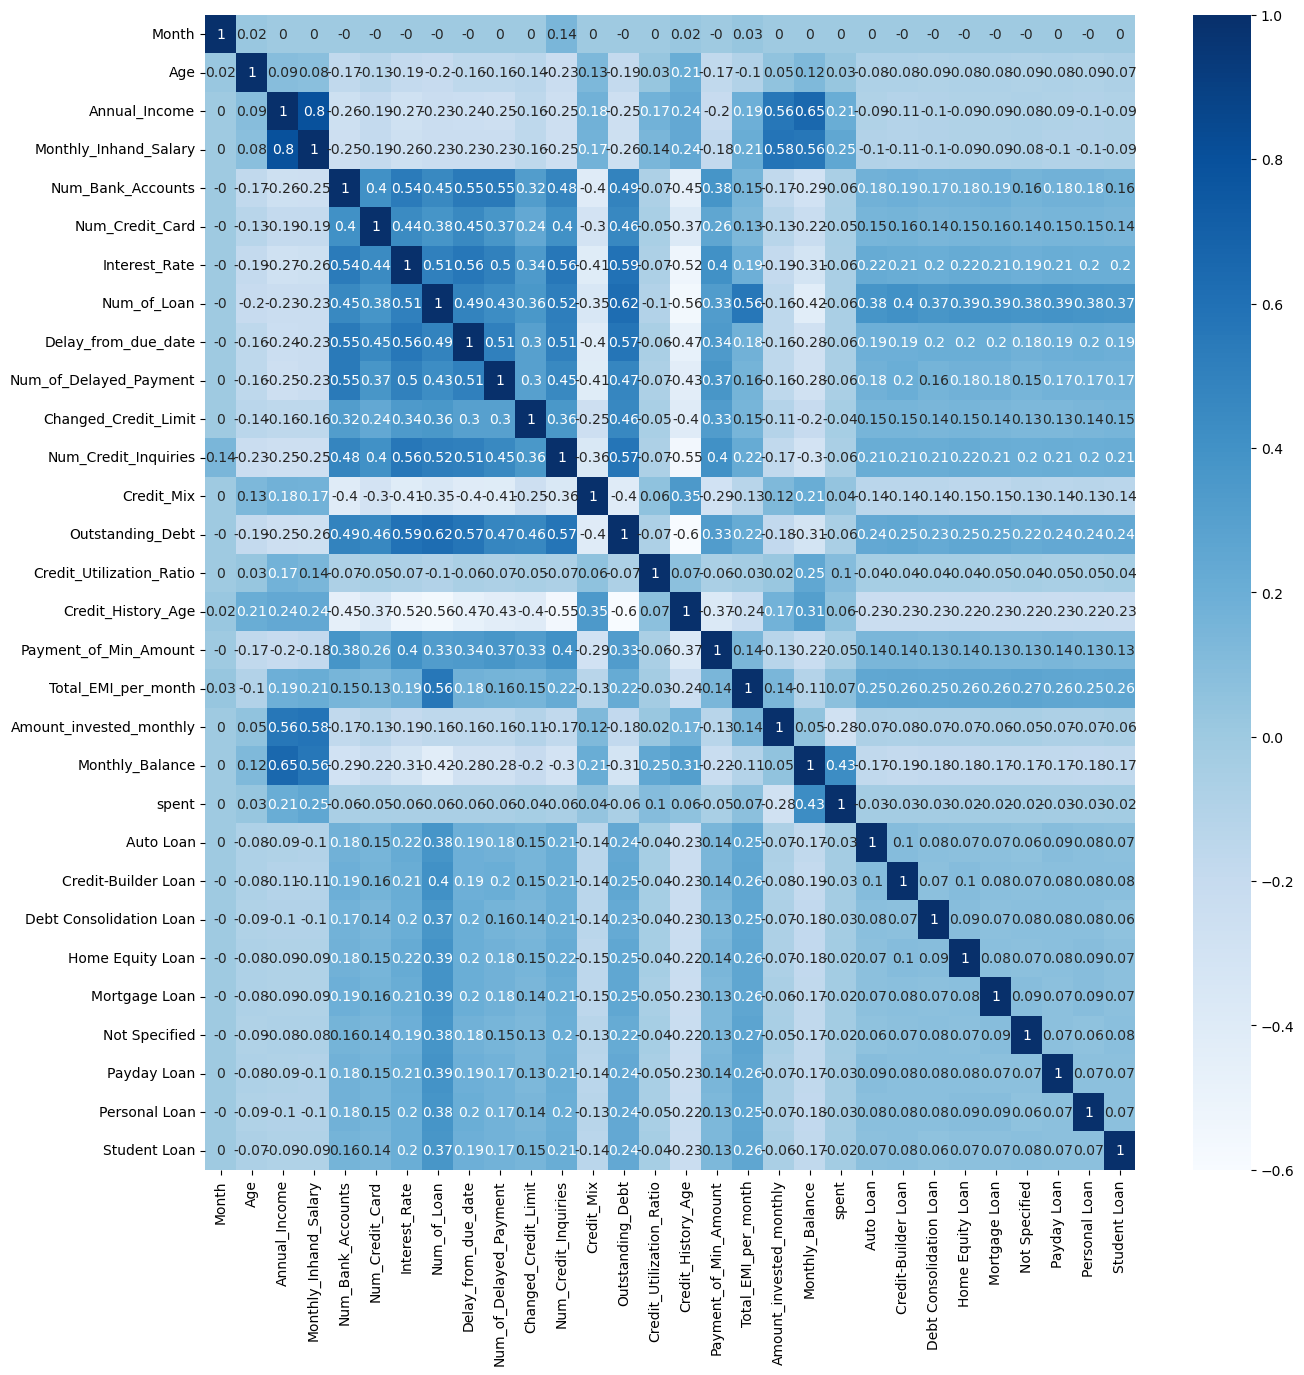

In [59]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr().round(2), cmap="Blues", annot=True)

In [60]:
df.columns

Index(['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'spent', 'Auto Loan',
       'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan',
       'Mortgage Loan', 'Not Specified', 'Payday Loan', 'Personal Loan',
       'Student Loan'],
      dtype='object')

In [61]:
#zawód i miesiąc są równomiernie rozłożone i nie wykazywały wpływu na rating kredytowy
df = df.drop(columns=['Occupation','Month'])
df.drop(columns=['Personal Loan','Student Loan','Payday Loan','Not Specified','Mortgage Loan', 'Home Equity Loan','Debt Consolidation Loan', 
'Credit-Builder Loan', 'Auto Loan' ], inplace=True)

In [62]:
#annual income i monthly salary bardzo skorelowane

In [63]:
df.Monthly_Inhand_Salary.corr(df_target)

-0.007045181313751734

In [64]:
df.Annual_Income.corr(df_target)

-0.005534996962539308

In [65]:
df = df.drop(columns=['Annual_Income'])

<AxesSubplot:>

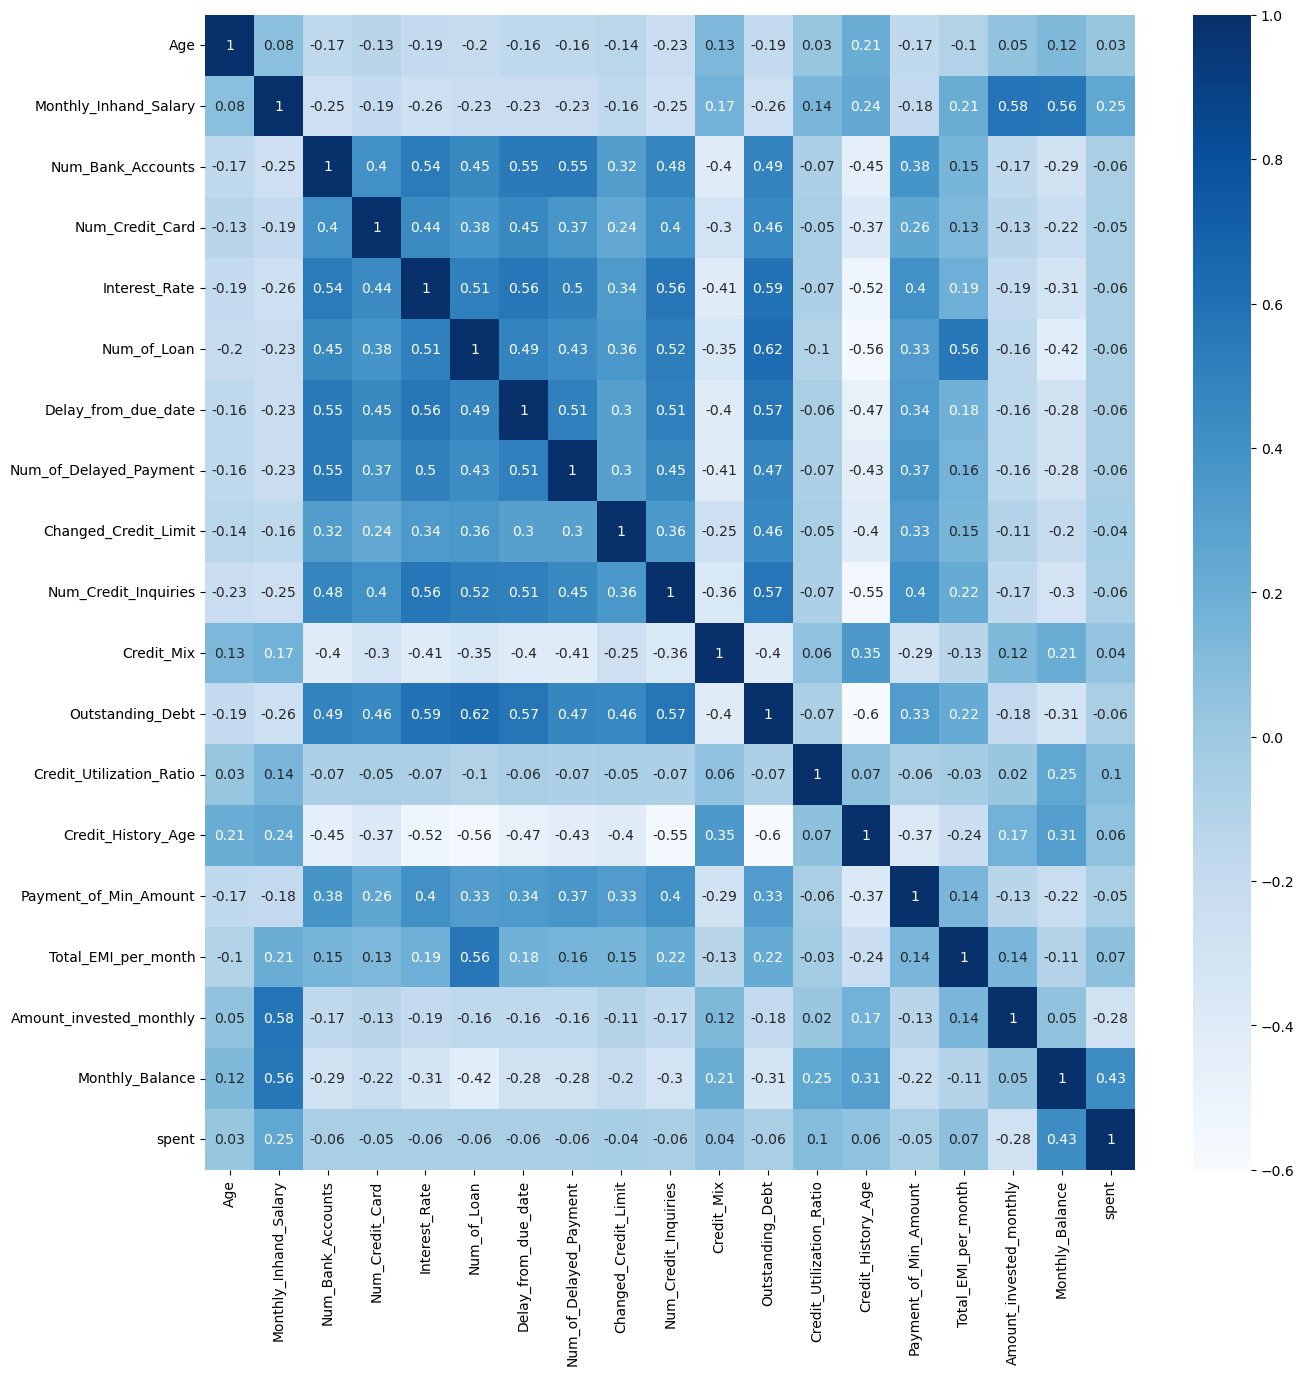

In [66]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr().round(2), cmap="Blues", annot=True)

In [67]:
df.info()
#ready :))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66888 entries, 0 to 66887
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       66888 non-null  float64
 1   Monthly_Inhand_Salary     66888 non-null  float64
 2   Num_Bank_Accounts         66888 non-null  float64
 3   Num_Credit_Card           66888 non-null  float64
 4   Interest_Rate             66888 non-null  float64
 5   Num_of_Loan               66888 non-null  float64
 6   Delay_from_due_date       66888 non-null  float64
 7   Num_of_Delayed_Payment    66888 non-null  float64
 8   Changed_Credit_Limit      66888 non-null  float64
 9   Num_Credit_Inquiries      66888 non-null  float64
 10  Credit_Mix                66888 non-null  int64  
 11  Outstanding_Debt          66888 non-null  float64
 12  Credit_Utilization_Ratio  66888 non-null  float64
 13  Credit_History_Age        66888 non-null  float64
 14  Paymen